In [1]:
import os

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# import Dataset from dataloader.py
from dataloader import VideoAudioDataset, get_random_segment

# !! Put data file location in file `data_filepath`
# If file `data_filepath` does not exist, assume data is located in root
filepath = 'vis-data-256/vis-data-256/'

if os.path.isfile('data_filepath'):
    with open('data_filepath', 'r') as f:
        filepath = f.readline() + filepath

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)


cuda


In [2]:
train_dataset = np.load('datasets/train_dataset.npy')
dataset = VideoAudioDataset(train_dataset, device, filepath_prefix=filepath, transform=get_random_segment)

# Model Example

In [3]:
from models import VideoAudioMatchingModel

model = VideoAudioMatchingModel().to(device)

c:\Users\gioef\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
video, audio, label = dataset[0]
video = video.unsqueeze(0)
audio = audio.unsqueeze(0)
video = video.to(device)
audio = audio.to(device)

In [5]:
video.shape, audio.shape

(torch.Size([1, 9, 3, 256, 456]), torch.Size([1, 32000]))

In [6]:
output = model(video, audio)

In [7]:
output

tensor([[0.4883]], device='cuda:0', grad_fn=<SigmoidBackward0>)

# Training Loop

In [8]:
from models import VideoAudioMatchingModel

model = VideoAudioMatchingModel().to(device)

In [9]:
train_dataset = np.load('datasets/train_dataset.npy')
# remove 2015-09-12-04-15-35-1_mic.wav row
train_dataset = train_dataset[train_dataset[:, 1] != '2015-09-12-04-15-35-1_mic.wav']
val_dataset = np.load('datasets/val_dataset.npy')
test_dataset = np.load('datasets/test_dataset.npy')

train_dataset_cls = VideoAudioDataset(train_dataset, device, filepath_prefix=filepath, transform=get_random_segment, downsample_factor=5)
val_dataset_cls = VideoAudioDataset(val_dataset, device, filepath_prefix=filepath, transform=get_random_segment, downsample_factor=5)
test_dataset_cls = VideoAudioDataset(test_dataset, device, filepath_prefix=filepath, transform=get_random_segment, downsample_factor=5)

train_dataloader = DataLoader(train_dataset_cls, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset_cls, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset_cls, batch_size=1, shuffle=False)

In [10]:
# train

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
no_epochs = 10
accumulate_gradients = 10  # Number of mini-batches to accumulate gradients over
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

model.train()
for epoch in range(no_epochs):

    running_loss = 0
    running_corrects = 0
    total_samples = 0


    for batch_idx, (video, audio, label) in enumerate(train_dataloader):
        video = video.to(device)
        audio = audio.to(device)
        label = label.to(device)

        # Forward pass
        outputs = model(video, audio).squeeze()  # (batch_size, 1) -> (batch_size)
        loss = criterion(outputs, label.float())

        # Backward and optimize
        loss.backward()
        running_loss += loss.item()
        total_samples += label.size(0)

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        running_corrects += (predictions == label.float()).sum().item()

        if (batch_idx + 1) % accumulate_gradients == 0:
            optimizer.step()
            optimizer.zero_grad()
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, no_epochs, batch_idx + 1, len(train_dataloader), running_loss / (batch_idx + 1)))

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(running_corrects / total_samples)

    running_val_loss = 0
    running_val_corrects = 0
    total_val_samples = 0

    model.eval()
    with torch.no_grad():
        for batch_idx, (video, audio, label) in enumerate(val_dataloader):

            video = video.to(device)
            audio = audio.to(device)
            label = label.to(device)

            # Forward pass
            outputs = model(video, audio).squeeze()  # (batch_size, 1) -> (batch_size)
            loss = criterion(outputs, label.float())
            running_val_loss += loss.item()
            total_val_samples += label.size(0)

            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            running_val_corrects += (predictions == label.float()).sum().item()

    val_losses.append(running_val_loss / len(val_dataloader))
    val_accuracies.append(running_val_corrects / total_val_samples)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch + 1, no_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))
    model.train()


Epoch [1/10], Step [10/195], Loss: 0.7076
Epoch [1/10], Step [20/195], Loss: 0.7006
Epoch [1/10], Step [30/195], Loss: 0.6785
Epoch [1/10], Step [40/195], Loss: 0.6718
Epoch [1/10], Step [50/195], Loss: 0.6726
Epoch [1/10], Step [60/195], Loss: 0.6654
Epoch [1/10], Step [70/195], Loss: 0.6610
Epoch [1/10], Step [80/195], Loss: 0.6491
Epoch [1/10], Step [90/195], Loss: 0.6410
Epoch [1/10], Step [100/195], Loss: 0.6360
Epoch [1/10], Step [110/195], Loss: 0.6336
Epoch [1/10], Step [120/195], Loss: 0.6271
Epoch [1/10], Step [130/195], Loss: 0.6205
Epoch [1/10], Step [140/195], Loss: 0.6151
Epoch [1/10], Step [150/195], Loss: 0.6076
Epoch [1/10], Step [160/195], Loss: 0.6038
Epoch [1/10], Step [170/195], Loss: 0.5959
Epoch [1/10], Step [180/195], Loss: 0.5892
Epoch [1/10], Step [190/195], Loss: 0.5820
Epoch [1/10], Train Loss: 0.5773, Train Acc: 0.7218, Val Loss: 0.9089, Val Acc: 0.5000
Epoch [2/10], Step [10/195], Loss: 0.5511
Epoch [2/10], Step [20/195], Loss: 0.5025
Epoch [2/10], Step [3

KeyboardInterrupt: 

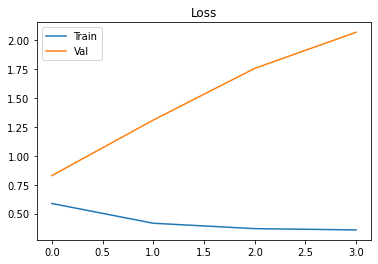

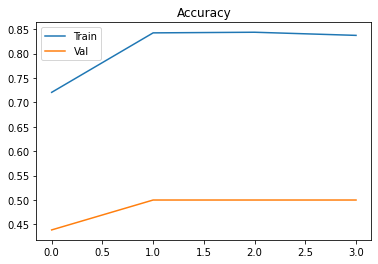

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()
